Attentions
==========

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/keisen/tf-keras-vis/blob/master/examples/attentions.ipynb)
[![Right click and save](https://img.shields.io/badge/Notebook-Open_In_Github-orange.svg)](https://github.com/keisen/tf-keras-vis/blob/master/docs/examples/attentions.ipynb)


This notebook explains how to get various attention images with Saliency, SmoothGrad, GradCAM, GradCAM++ and ScoreCAM/Faster-ScoreCAM.


Preparation
-----------

### Load libraries

In [56]:
!pip install tf-keras-vis

In [57]:
## load package
%reload_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tf_keras_vis.utils import num_of_gpus
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from sklearn.model_selection import train_test_split
_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 1 GPUs


### Load tf.keras.Model

In this notebook, we use VGG16 model, but if you want to use other tf.keras.Model, you can do so by modifying the section below.

In [58]:
from tensorflow.keras.applications.vgg19 import VGG19 as Model

model = Model(weights='imagenet', include_top=True)
model.compile(
        loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.01), metrics=["accuracy"]
    )
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Load and preprocess images

tf-keras-vis supports batch-wise visualization. Here, we load and preprocess three pictures of goldfish, bear and assault-rifle as input data.

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
%cd "/content/drive/MyDrive/Ahnaf_Sadat/EE_526/Project"

/content/drive/MyDrive/Ahnaf_Sadat/EE_526/Project


In [61]:
%cd "Image/ImageNet/original_images"

/content/drive/MyDrive/Ahnaf_Sadat/EE_526/Project/Image/ImageNet/original_images


In [62]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

original_image_array = list()
list_of_names = os.listdir()
list_of_names.sort()
for img_name in list_of_names:
  # Load the image
  image = Image.open(img_name)

  # Convert the image to a numpy array
  original_image_array.append(np.array(image))

In [63]:
index = 90

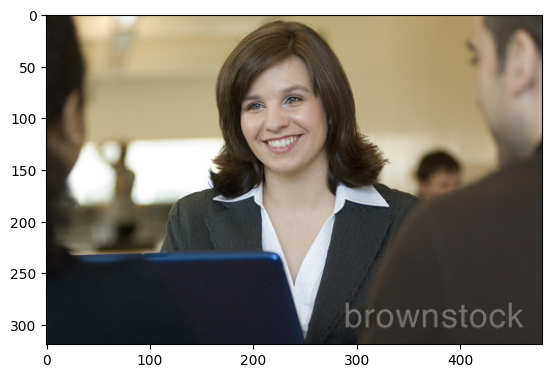

In [64]:
# Display the first image
original_image = original_image_array[index]
plt.imshow(original_image)
plt.show()

In [65]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

def change_size_for_model(image):
    img = array_to_img(image, scale=False) #returns PIL Image
    img = tf.image.resize(image, (224, 224)) #resize image
    arr = img_to_array(img) #convert back to array
    return arr.astype(np.int16)

def change_size_for_original(image, original_shape):
    img = array_to_img(image, scale=False) #returns PIL Image
    img = tf.image.resize(image, original_shape) #resize image
    arr = img_to_array(img) #convert back to array
    return arr.astype(np.int16)

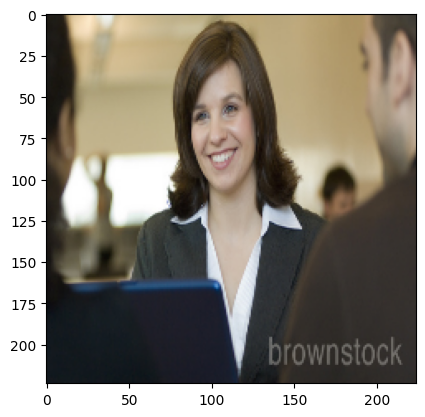

In [66]:
# Display the first image
new_img = change_size_for_model(original_image_array[index])
plt.imshow(new_img)
plt.show()

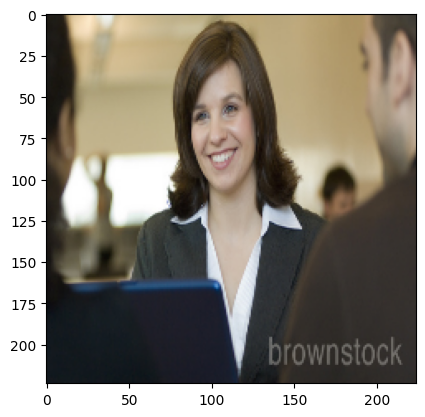

In [67]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input

# Image titles
# image_titles = ['Ant']

# Load images and Convert them to a Numpy array
# img1 = load_img('images/goldfish.jpg', target_size=(224, 224))
# img2 = load_img('images/bear.jpg', target_size=(224, 224))
# img3 = load_img('images/soldiers.jpg', target_size=(224, 224))
# images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

# Preparing input data for VGG16
X = new_img

plt.imshow(X)
plt.show()

In [68]:
np.shape(X)

(224, 224, 3)

In [69]:
result = model.predict(new_img.reshape(1,224,224,3))
np.argmax(result[0])

1/1 [==============================] - 0s 309ms/step


681

In [70]:
%cd ..
%cd ..
%cd ..
%cd Scripts
# importing the module
import ast

# reading the data from the file
with open('labels.txt') as f:
	data = f.read()

print("Data type before reconstruction : ", type(data))

# reconstructing the data as a dictionary
labels = ast.literal_eval(data)
labels[np.argmax(result[0])]

/content/drive/MyDrive/Ahnaf_Sadat/EE_526/Project/Image/ImageNet
/content/drive/MyDrive/Ahnaf_Sadat/EE_526/Project/Image
/content/drive/MyDrive/Ahnaf_Sadat/EE_526/Project
/content/drive/MyDrive/Ahnaf_Sadat/EE_526/Project/Scripts
Data type before reconstruction :  <class 'str'>


'notebook, notebook computer'

In [71]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Instead of using the ReplaceToLinear instance above,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

In [72]:
from tf_keras_vis.utils.scores import CategoricalScore

score = CategoricalScore([np.argmax(result[0])])

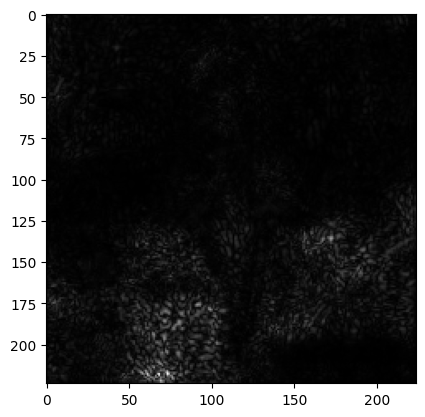

CPU times: user 1.28 s, sys: 958 ms, total: 2.24 s
Wall time: 2.96 s


In [73]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map
saliency_map = saliency(score, X.astype(np.float32))

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

plt.imshow(saliency_map.reshape(224,224), cmap='gray')
plt.show()

# imshow(saliency_map[i], cmap='gray')

# # Render
# # f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
# # for i, title in enumerate(image_titles):
# #     ax[i].set_title(title, fontsize=16)
# #     ax[i].imshow(saliency_map[i], cmap='gray')
# #     ax[i].axis('off')
# plt.tight_layout()
# plt.show()

In [1]:
%%time

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(score,
                        X.astype(np.float32),
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.10) # noise spread level.

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)
plt.imshow(saliency_map.reshape(224,224), cmap='jet')
plt.show()


# Render
# f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
# for i, title in enumerate(image_titles):
#     ax[i].set_title(title, fontsize=14)
#     ax[i].imshow(saliency_map[i], cmap='jet')
#     ax[i].axis('off')
# plt.tight_layout()
# plt.savefig('images/smoothgrad.png')
# plt.show()

NameError: name 'saliency' is not defined

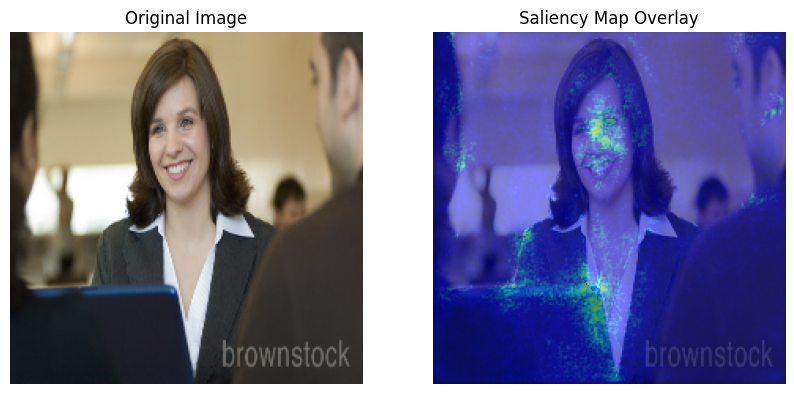

In [75]:
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(X, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Saliency map superimposed on the original image
plt.subplot(1, 2, 2)
plt.imshow(X, cmap='gray')  # Show the original image first
plt.imshow(saliency_map.reshape(224,224), cmap='jet', alpha=0.5)  # Overlay the saliency map with transparency
plt.title('Saliency Map Overlay')
plt.axis('off')

plt.show()

ScoreCAM

In [76]:
%%time

from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils import num_of_gpus
from matplotlib import cm

# Create ScoreCAM object
scorecam = Scorecam(model)

# Generate heatmap with ScoreCAM
cam = scorecam(score, X, penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)
heatmap = np.uint8(cm.jet(cam[0])* 255)
# plt.imshow(saliency_map.reshape(224,224), cmap='gray')
# plt.imshow(heatmap, cmap='jet', alpha=0.5)
# Render
# f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
# for i, title in enumerate(image_titles):
#     heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
#     ax[i].set_title(title, fontsize=16)
#     ax[i].imshow(images[i])
#     ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
#     ax[i].axis('off')
# plt.tight_layout()
# plt.show()

16/16 [==============================] - 2s 145ms/step
CPU times: user 11.2 s, sys: 862 ms, total: 12.1 s
Wall time: 16.7 s


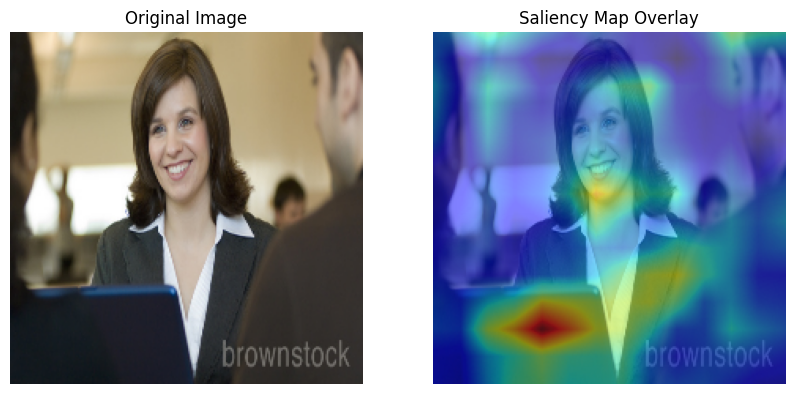

In [77]:
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(X, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Saliency map superimposed on the original image
plt.subplot(1, 2, 2)
plt.imshow(X, cmap='gray')  # Show the original image first
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay the saliency map with transparency
plt.title('Saliency Map Overlay')
plt.axis('off')

plt.show()

In [78]:
%%time

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X.astype(np.float32),
              penultimate_layer=-1)
heatmap = np.uint8(cm.jet(cam[0])* 255)
## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# # Render
# f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
# for i, title in enumerate(image_titles):
#     heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
#     ax[i].set_title(title, fontsize=16)
#     ax[i].imshow(images[i])
#     ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
#     ax[i].axis('off')
# plt.tight_layout()
# plt.show()

CPU times: user 892 ms, sys: 743 ms, total: 1.63 s
Wall time: 1.66 s


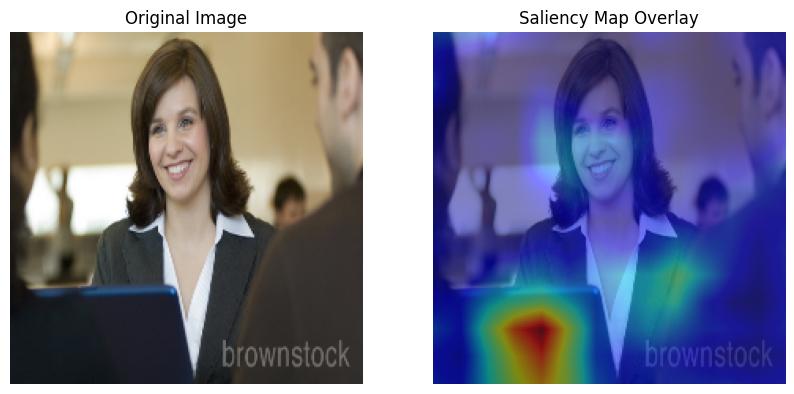

In [79]:
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(X, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Saliency map superimposed on the original image
plt.subplot(1, 2, 2)
plt.imshow(X, cmap='gray')  # Show the original image first
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay the saliency map with transparency
plt.title('Saliency Map Overlay')
plt.axis('off')

plt.show()

In [80]:
fsdgdhgjukouiouiu

NameError: name 'fsdgdhgjukouiouiu' is not defined

In [ ]:
X.astype(np.float32)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input

# Image titles
image_titles = ['Goldfish', 'Bear', 'Assault rifle']

# Load images and Convert them to a Numpy array
img1 = load_img('images/goldfish.jpg', target_size=(224, 224))
img2 = load_img('images/bear.jpg', target_size=(224, 224))
img3 = load_img('images/soldiers.jpg', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

# Preparing input data for VGG16
X = preprocess_input(images)

# Rendering
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

Implement functions required to use attentions
----------------------------------------------

### Model modifier

When the softmax activation function is applied to the last layer of model, it may obstruct generating the attention images, so you should replace the function to a linear activation function. Although we create and use `ReplaceToLinear` instance here, we can also use the model modifier function defined by ourselves.

In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Instead of using the ReplaceToLinear instance above,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

### Score function

And then, you **MUST** create `Score` instance or define `score function` that returns target scores. Here, they return the score values corresponding Goldfish, Bear, Assault Rifle.

In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore([1, 294, 413])

# Instead of using CategoricalScore object,
# you can also define the function from scratch as follows:
def score_function(output):
    # The `output` variable refers to the output of the model,
    # so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
    return (output[0][1], output[1][294], output[2][413])

## Vanilla Saliency

`Saliency` generates a saliency map that appears the regions of ​​the input image that contributes the most to the output value.

In [ ]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map
saliency_map = saliency(score, X)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## SmoothGrad

As you can see above, Vanilla Saliency map is too noisy, so let's remove noise in the saliency map using SmoothGrad! SmoothGrad is a method that reduce the noise in saliency map by adding noise to input image.

**Note:** Because SmoothGrad calculates the gradient repeatedly, it might take much time around 2-3 minutes when using CPU.

In [ ]:
%%time

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(score,
                        X,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('images/smoothgrad.png')
plt.show()

## GradCAM

Saliency is one of useful way of visualizing attention that appears the regions of the input image that contributes the most to the output value.
GradCAM is another way of visualizing attention over input. Instead of using gradients of model outputs, it uses of penultimate layer output (that is the convolutional layer just before Dense layers).

In [ ]:
%%time

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

As you can see above, GradCAM is useful method for intuitively knowing where the attention is. However, when you take a look closely, you'll see that the visualized attentions don't completely cover the target (especially the head of Bear) in the picture.

Okay then, let's move on to next method that is able to fix the problem above you looked.

## GradCAM++

GradCAM++ can provide better visual explanations of CNN model predictions.

In [ ]:
%%time

from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from matplotlib import cm

# Create GradCAM++ object
gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)

# Generate heatmap with GradCAM++
cam = gradcam(score,
              X,
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('images/gradcam_plus_plus.png')
plt.show()

As you can see above, Now, the visualized attentions almost completely cover the target objects!

## ScoreCAM

In the end, Here, we show you ScoreCAM. It is an another method that generates Class Activation Map. The characteristic of this method is that it's the `gradient-free` method unlike GradCAM, GradCAM++ or Saliency.

In [ ]:
%%time

from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils import num_of_gpus

# Create ScoreCAM object
scorecam = Scorecam(model)

# Generate heatmap with ScoreCAM
cam = scorecam(score, X, penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

As you can see above, The visualized images are more sophisticated!

## Faster-ScoreCAM

ScoreCAM is a great method, however, it takes a bit more time to process it than other cam methods.
There is a good news for us. Faster-ScorecAM that makes ScoreCAM to be more efficient was devised by @tabayashi0117.

https://github.com/tabayashi0117/Score-CAM/blob/master/README.md#faster-score-cam

> We thought that several channels were dominant in generating the final heat map. Faster-Score-CAM adds the processing of “use only channels with large variances as mask images” to Score-CAM. (max_N = -1 is the original Score-CAM).


In [ ]:
%%time

from tf_keras_vis.scorecam import Scorecam

# Create ScoreCAM object
scorecam = Scorecam(model, model_modifier=replace2linear)

# Generate heatmap with Faster-ScoreCAM
cam = scorecam(score,
               X,
               penultimate_layer=-1,
               max_N=10)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()